# Build Text-Numeric-Categorical Hybrid Functional Model Using Word 2 Vec, Tensorflow, Keras APIs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import pydot_ng as pydot
#import graphviz
import seaborn as sns
%matplotlib inline
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import (auc, average_precision_score, brier_score_loss, confusion_matrix, fbeta_score,
                             precision_recall_curve, roc_curve)
 
from gensim.models import Word2Vec
 
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
#from plot_model import plot_model
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddharthchaudhary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddharthchaudhary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Define PR Curve Function for Model Comparison

In [2]:
def pr_curve(y_true, y_prob):
 
    lines = precision_recall_curve(probas_pred=y_prob, y_true=y_true)
    pr_auc = round(average_precision_score(y_true=y_true, y_score=y_prob), 3)
 
    plt.plot(lines[1], lines[0], label='Precision-Recall Curve (Area = {})'.format(pr_auc))
 
    plt.title('Precision-Recall Curve:' , y=1.05)
    plt.xlabel('Recall: P(predicted+|true+)')
    plt.ylabel('Precision: P(true+|predicted+)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.tick_params(
            axis='both',
            which='both',
            labelright=False,
            top=False,
            right=False)
    plt.tight_layout()
    plt.show()

## Define Function to Plot Positive and Negative Score Distributions

In [3]:
def plot_validation_groups(y_true, y_prob, positive_alpha=0.9, negative_alpha=0.5, bins=40, x_size=12, y_size=12):
 
    cols = ['ACTUAL', 'PROB_POSITIVE']
    data = [y_true, y_prob]
    df = pd.DataFrame(dict(zip(cols, data)))
 
    positive_group = df[df.ACTUAL == 1]
    negative_group = df[df.ACTUAL == 0]
    
    plt.figure(figsize=(x_size, y_size))
    plt.hist(negative_group.PROB_POSITIVE, alpha=negative_alpha, label='Negative Class', bins=bins, color='orange')
    plt.hist(positive_group.PROB_POSITIVE, alpha=positive_alpha, label='Positive Class', bins=bins, color='b')
    plt.legend(loc='upper right')
    plt.title(f"Test Set Score Distribution \n ({round((positive_group.shape[0]/df.shape[0])*100, 2)}% Prevalence)")
    plt.xlabel("Risk Score")
    plt.ylabel("Frequency")
 
    plt.show()

## Define Function to Plot Performance at Various Thresholds

In [4]:
def comp_threshold(y_true, y_prob):
        
    cols = ['Threshold', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'Accuracy', 'True Negative Rate',
                'False Positive Rate', 'False Negative Rate', 'True Positive Rate', 'F1 Score', 'Brier Loss']
        
    results = []
    prediction_probabilities_clf = y_prob
 
    for i in range(5, 100, 5):
 
        threshold = float(i) / 100
        prediction_clf = [1 if el > threshold else 0 for el in prediction_probabilities_clf] 
        cm = confusion_matrix(y_true, prediction_clf)
        brier_loss = round(brier_score_loss(y_true, prediction_clf), 4)
 
        true_negatives = float(cm[0][0])
        false_positives = float(cm[0][1])
        false_negatives = float(cm[1][0])
        true_positives = float(cm[1][1])
 
        sensitivity = round((true_positives / (true_positives + false_negatives)),
                                4) if (true_positives + false_negatives) > 0 else 999
        specificity = round((true_negatives / (false_positives + true_negatives)),
                                4) if (false_positives + true_negatives) > 0 else 999
        positive_predictive_value = round((true_positives / (true_positives + false_positives)),
                                              4) if (true_positives + false_positives) > 0 else 999
        negative_predictive_value = round((true_negatives / (false_negatives + true_negatives)),
                                              4) if (false_negatives + true_negatives) > 0 else 999
        accuracy = round((true_positives + true_negatives) / (
                    true_positives + true_negatives + false_positives + false_negatives),
                             4) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 999
        f1_score = round(((sensitivity * positive_predictive_value) / (sensitivity + positive_predictive_value)),
                             4) if (sensitivity + positive_predictive_value) > 0 else 999
 
        def get_percent(measure):
            total = float(len(y_true))
            m = int(measure)
            prop = round(((m / total) * 100), 2)
            return str(prop) + '%'
 
        true_negative_percent = get_percent(true_negatives)
        false_positive_percent = get_percent(false_positives)
        false_negative_percent = get_percent(false_negatives)
        true_positive_percent = get_percent(true_positives)
 
        results.append([threshold, sensitivity, specificity, positive_predictive_value, negative_predictive_value,
                        accuracy, true_negative_percent, false_positive_percent, false_negative_percent,
                        true_positive_percent, f1_score, brier_loss])
        
    results_df = pd.DataFrame(results, columns=cols)
    
    return results_df

## Define Function to Print Confusion Matrix

In [5]:
def print_performance(y_true, y_prob, threshold=0.5):
    
    cm = confusion_matrix(y_true, [1 if el > threshold else 0 for el in y_prob])
 
    true_negatives = float(cm[0][0])
    false_positives = float(cm[0][1])
    false_negatives = float(cm[1][0])
    true_positives = float(cm[1][1])
    try:
        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (false_positives + true_negatives)
        positive_predictive_value = true_positives / (true_positives + false_positives)
        negative_predictive_value = true_negatives / (false_negatives + true_negatives)
        accuracy = (true_positives + true_negatives) / (
                   true_positives + true_negatives + false_positives + false_negatives)
    except:
        print(cm)
        return
    
    print('')
    print('CONFUSION MATRIX AT {} THRESHOLD:'.format(threshold))
    print('')
    print(cm)
    print('')
    print('PERFORMANCE AT {} THRESHOLD:'.format(threshold))
    print('')
    print("   Recall/Sensitivity: {}".format(round(sensitivity, 5)))
    print("   Specificity: {}".format(round(specificity, 5)))
    print("   Precision/Positive Predictive Value: {}".format(round(positive_predictive_value, 5)))
    print("   Negative Predictive Value: {}".format(round(negative_predictive_value, 5)))
    print("   plot_accuracy: {}".format(round(accuracy, 5)))
    print('')

## PARAMETERS

In [6]:
# Saving Tokenizer to this location
base_path = '/Users/siddharthchaudhary/Documents/git_repos/AI-Models/Numeric_text_classifier/'
tokenized_path = base_path + 'tokenizer.pickle'
model_result = base_path + 'model_result/model.keras'

# Numeric dataset total features
num_features = 32 #Number of Columns/Features in Numeric dataset

# Embedding Params
EMBEDDING_DIM = 40
NUM_DISTINCT_WORDS = 1000 # the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept
MAX_SEQ_LEN = 70
OOV_TOKEN = '<OOV>'
PAD_TOKEN = '<PAD>'
PAD_TOKEN_IDX = 0

# Define VERBOSE
VERBOSE = 1


## Load datasets

In [7]:
train_data = pd.read_csv(base_path + 'train_data.csv')
train_df = pd.read_csv(base_path + 'train.csv')
val_df = pd.read_csv(base_path + 'val.csv')
test_df = pd.read_csv(base_path + 'test.csv')
test_blncd_df = pd.read_csv(base_path + 'test_blncd_df.csv')

In [8]:
train_df.head()

,Age,Rating,labels,Positive Feedback Count,text,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,47,5,1,0,Comfy shirt- This shirt is so pretty and casua...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,46,2,0,0,"Doesn't breath- The stone color was nice, but ...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,2,0,15,"Not flattering- I love the idea of this top, b...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,29,2,0,26,Not made right- This has such awful proportion...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,54,3,0,0,Boxy- I ordered this sweater in black and thou...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Preprocess for non_text and creating labels for both

In [9]:
X_train = train_df.drop(['text', 'labels'], axis=1)
X_val = val_df.drop(['text', 'labels'], axis=1)
X_test = test_df.drop(['text', 'labels'], axis=1)
X_test_blncd = test_blncd_df.drop(['text', 'labels'], axis=1)

y_train = train_df['labels'].values
y_val = val_df['labels'].values
y_test = test_df['labels'].values
y_test_blncd = test_blncd_df['labels'].values

In [10]:
print(y_val.dtype)

int64


In [11]:
X_train.head()

,Age,Rating,Positive Feedback Count,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,47,5,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,46,2,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,2,15,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,29,2,26,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,54,3,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
X_test_blncd = sc.transform(X_test_blncd)

In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_test_blncd.shape)

(6022, 32)
(1966, 32)
(984, 32)
(352, 32)


## Preprocessing text data

### Lowercase text data

In [14]:
train_data['text'] = train_data['text'].apply(lambda x: x.lower())
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
val_df['text'] = val_df['text'].apply(lambda x: x.lower())
test_df['text'] = test_df['text'].apply(lambda x: x.lower())
test_blncd_df['text'] = test_blncd_df['text'].apply(lambda x: x.lower())
train_df.head()

,Age,Rating,labels,Positive Feedback Count,text,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,47,5,1,0,comfy shirt- this shirt is so pretty and casua...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,46,2,0,0,"doesn't breath- the stone color was nice, but ...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,2,0,15,"not flattering- i love the idea of this top, b...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,29,2,0,26,not made right- this has such awful proportion...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,54,3,0,0,boxy- i ordered this sweater in black and thou...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Removing Stopwords Using NLTK

In [15]:
stop_words = stopwords.words('english')
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
val_df['text'] = val_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_blncd_df['text'] = test_blncd_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

### Lemmatise Text Using NLTK

In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
train_data['text'] = train_data['text'].apply(lemmatize_words)
train_df['text'] = train_df['text'].apply(lemmatize_words)
val_df['text'] = val_df['text'].apply(lemmatize_words)
test_df['text'] = test_df['text'].apply(lemmatize_words)
test_blncd_df['text'] = test_blncd_df['text'].apply(lemmatize_words)

In [17]:
train_df.head()

,Age,Rating,labels,Positive Feedback Count,text,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,47,5,1,0,comfy shirt- shirt pretty casual however nice ...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,46,2,0,0,"breath- stone color nice, material heavy breat...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,2,0,15,"flattering- love idea top, wish much fabric. w...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,29,2,0,26,"make right- awful proportions. 5'0 100 lbs, or...",True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,54,3,0,0,boxy- order sweater black think pretty design ...,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Define a Tokenizer for the Text Data

### I have already created the tokenizer and saved it. That's why I changed the saving cell below as Raw 

In [18]:
tokenizer = Tokenizer(
    num_words=NUM_DISTINCT_WORDS,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=OOV_TOKEN
)

## Fit the Tokenizer to the Train Set

In [19]:
tokenizer.fit_on_texts(train_data['text'].tolist())

## Saving and loading tokenized data for external Charts

In [20]:
# saving
with open(tokenized_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# loading
with open(tokenized_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

## Examine Tokenizer Properties

In [22]:
print(f'Number of words: {tokenizer.num_words}')
print(f'Out of vocab token: {tokenizer.oov_token}')

Number of words: 1000
Out of vocab token: <OOV>


In [23]:
print(tokenizer.word_index)

{'<OOV>': 1, 'dress': 2, 'love': 3, 'fit': 4, 'size': 5, 'wear': 6, 'top': 7, 'look': 8, 'like': 9, 'great': 10, 'color': 11, 'it': 12, 'fabric': 13, 'small': 14, 'would': 15, 'get': 16, 'order': 17, 'perfect': 18, 'cute': 19, 'beautiful': 20, 'go': 21, 'buy': 22, 'really': 23, 'make': 24, 'little': 25, 'one': 26, 'soft': 27, 'try': 28, 'nice': 29, 'run': 30, 'comfortable': 31, 'well': 32, 'think': 33, 'back': 34, 'shirt': 35, 'me': 36, 'large': 37, 'sweater': 38, 'work': 39, 'pretty': 40, 'much': 41, 'material': 42, 'bite': 43, 'length': 44, 'long': 45, 'jeans': 46, 'also': 47, 'quality': 48, 'petite': 49, 'waist': 50, 'short': 51, 'skirt': 52, 'flatter': 53, 'even': 54, 'medium': 55, 'purchase': 56, 'want': 57, 'feel': 58, 'xs': 59, 'retailer': 60, 'good': 61, 'style': 62, 'store': 63, 'see': 64, 'big': 65, 'find': 66, 'super': 67, 'cut': 68, 'usually': 69, 'summer': 70, 'way': 71, 'could': 72, 'flattering': 73, 'black': 74, 'design': 75, 'fall': 76, 'right': 77, 'still': 78, 'sleeve

## Tokenize the Text Data

In [24]:
train_tokens = tokenizer.texts_to_sequences(train_df['text'].tolist())
val_tokens = tokenizer.texts_to_sequences(val_df['text'].tolist())
test_tokens = tokenizer.texts_to_sequences(test_df['text'].tolist())
test_blncd_tokens = tokenizer.texts_to_sequences(test_blncd_df['text'].tolist())

In [25]:
# Erase Pointers to releasing occupied memory
del train_df
del test_df

## View the Distribution of Words per Review

<Figure size 640x480 with 0 Axes>

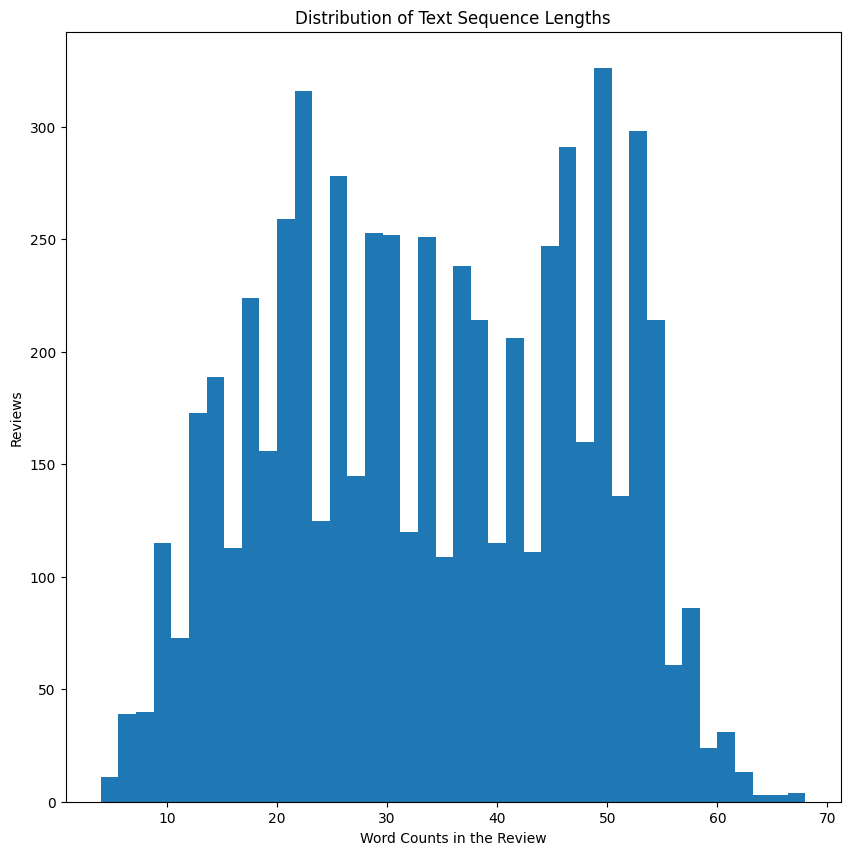

In [26]:
plt.clf()
plt.figure(figsize=(10, 10))
plt.hist([len(seq) for seq in train_tokens], bins = 40)
plt.title('Distribution of Text Sequence Lengths')
plt.ylabel('Reviews')
plt.xlabel('Word Counts in the Review')
plt.show()

## Check the Min and Max Token Values

In [27]:
print(f'Min token value: {min([min(x) for x in train_tokens])}')
print(f'Max token value: {max([max(x) for x in train_tokens])}')

Min token value: 1
Max token value: 999


## Pad the Token Sequences

In [28]:
padded_inputs = pad_sequences(
    train_tokens,
    maxlen=MAX_SEQ_LEN,
    value=PAD_TOKEN_IDX
)
padded_inputs_val = pad_sequences(
    val_tokens,
    maxlen=MAX_SEQ_LEN,
    value=PAD_TOKEN_IDX
)
padded_inputs_test = pad_sequences(
    test_tokens,
    maxlen=MAX_SEQ_LEN,
    value=PAD_TOKEN_IDX
)
padded_inputs_test_blncd = pad_sequences(
    test_blncd_tokens,
    maxlen=MAX_SEQ_LEN,
    value=PAD_TOKEN_IDX
)

In [29]:
# Erase Pointers to releasing occupied memory
del train_tokens
del test_tokens

In [30]:
oov_token_idx = tokenizer.word_index[tokenizer.oov_token]
oov_token_idx

1

In [31]:
corpus = []
for record in padded_inputs:
    corpus.append([str(x) for x in record if x not in [PAD_TOKEN_IDX, oov_token_idx]])

In [32]:
len(corpus)

6022

In [33]:
w2v_model = Word2Vec(
    corpus,
    vector_size=EMBEDDING_DIM,
    window=5, # use a context size of 5 for training
    min_count=1, # we already filtered for the top NUM_DISTINCT_WORDS
    sg=0 # uses CBOW if 0 and skip-gram if 1
)

In [34]:
init_params = tf.random_uniform_initializer().get_config()
 
embedding_matrix = np.random.uniform(
    low=init_params['minval'],
    high=init_params['maxval'],
    size=(NUM_DISTINCT_WORDS, EMBEDDING_DIM)
)
 
for i in range(0, NUM_DISTINCT_WORDS):
    if (i not in [PAD_TOKEN_IDX, oov_token_idx]) and (str(i) in w2v_model.wv.key_to_index):
        vector = w2v_model.wv[str(i)]  # Access the word vector
        embedding_matrix[i] = vector  # Store it in the embedding matrix
    else:
        print(f'Vector for token {i} will be randomly initialized.')

Vector for token 0 will be randomly initialized.
Vector for token 1 will be randomly initialized.


In [35]:
embedding_matrix

array([[ 0.00220469, -0.03255734, -0.0152744 , ...,  0.02060963,
        -0.00529129, -0.0296592 ],
       [ 0.04630992,  0.04762461, -0.007042  , ...,  0.04707877,
         0.04182566,  0.00570006],
       [-0.11396661, -0.26000655,  0.09028735, ..., -0.30688113,
        -0.65711844, -0.38756055],
       ...,
       [-0.08956432, -0.04178443, -0.33548653, ..., -0.2047192 ,
        -0.33470762, -0.23937002],
       [-0.01550164, -0.06936795, -0.32443115, ..., -0.23892698,
        -0.24896179, -0.28304118],
       [-0.26422653,  0.04876254, -0.52593261, ..., -0.33128771,
        -0.37619814, -0.2975769 ]])

## Build and Compile Model

Used the same comfiguration, reduced neurons from each layer as we have very less data compared to provider enabalement data
Multi input layer cant be build using sequential modelling it is done only via Functional modelling.
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
https://keras.io/guides/functional_api/

In [36]:
## Define INPUT LAYERS
text_input = tf.keras.Input(shape=(MAX_SEQ_LEN,), name="text")  # Variable-length sequence of ints
numeric_input = tf.keras.Input(shape=(num_features,), name="numeric")  # Binary vectors of size `num_tags`

# INPUT LAYERS FOR TEXT DATA
# Embed each word in the text into a 64-dimensional vector
text_features_embedding_layer = tf.keras.layers.Embedding(NUM_DISTINCT_WORDS, 
                                                          EMBEDDING_DIM, 
                                                          input_length=MAX_SEQ_LEN,
                                                          weights=[embedding_matrix], 
                                                          trainable = True)(text_input)

# Reduce sequence of embedded words in the body into a single 32-dimensional vector
text_features_layer_1 = (tf.keras.
                         layers.LSTM(40)
                         (text_features_embedding_layer))
text_features_layer_2 = (tf.keras.
                         layers.Dense(units = 64, activation='relu')
                         (text_features_layer_1))
text_features_dropout_1 = (tf.keras.
                           layers.Dropout(0.2)
                           (text_features_layer_2))
text_features_final_layer = (tf.keras.
                             layers.Dense(units = 64, activation='relu')
                             (text_features_dropout_1))


# INPUT LAYERS FOR NUMERIC DATA
num_features_layer_1 = (tf.keras.layers.Dense(units = 32, 
                                              kernel_initializer = 'uniform', 
                                              activation = 'relu')(numeric_input))
num_features_layer_2 = (tf.keras.layers.Dense(units = 64, 
                                              kernel_initializer = 'uniform', 
                                              activation = 'relu')(num_features_layer_1))
num_features_final_layer = (tf.keras.layers.Dense(units = 64, 
                                                  kernel_initializer = 'uniform', 
                                                  activation = 'relu')(num_features_layer_2))

# Merge all available features into a single large vector via concatenation
concatenated_layer = tf.keras.layers.concatenate([text_features_final_layer, 
                                                  num_features_final_layer])

# Two layers after concatening
post_concatenated_layer_1 = (tf.keras.layers.Dense(units = 64, 
                                                   activation = 'relu')(concatenated_layer))
post_concatenated_layer_2 = (tf.keras.layers.Dense(units = 64, 
                                                   activation = 'relu')(post_concatenated_layer_1))

# Stick a logistic regression for priority prediction on top of the features
# pred_layer = (tf.keras.layers.Dense(1, 
#                                    activation='sigmoid', 
#                                    name="recomendation")(post_concatenated_layer_2))
pred_layer = tf.keras.layers.Dense(1, activation='sigmoid')(post_concatenated_layer_2)

# Instantiate an end-to-end model predicting both priority and department
model = tf.keras.Model(
    inputs=[ text_input, numeric_input],
    outputs=[pred_layer]
)

/opt/anaconda3/envs/cat_num_text/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Compile Model

In [37]:
pr_metric = AUC(curve='PR', num_thresholds=1000)
LEARNING_RATE = 0.0001

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),  # Use 'learning_rate'
              metrics=[pr_metric],
              loss='binary_crossentropy')

## Used hypermater from previous experiment.
## Need to to do hyperpameter tuning
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
https://github.com/autonomio/talos/blob/9890d71d31451af3d7e8d91a75841bc7904db958/docs/Examples_Multiple_Inputs.md

https://github.com/keras-team/keras-tuner/issues/281

## View Model Summary

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 70)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 70, 40)    │     40,000 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 40)        │     12,960 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,624 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ numeric[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,112 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,553 (310.75 KB)

 Trainable params: 79,553 (310.75 KB)

 Non-trainable params: 0 (0.00 B)

## Define Callbacks for Model Training

In [39]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(model_result, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

## Fit the Model

In [40]:
history = model.fit(
    {"text": padded_inputs, "numeric": X_train},  # Input data
    y_train,  # Output labels
    validation_data=({"text": padded_inputs_val, "numeric": X_val}, y_val),  # Validation data
    epochs=15,  # Training for 15 epochs
    verbose=1,  # Show detailed logs during training
    callbacks=[model_ckpt, early_stop]  # Save best model and prevent overfitting
)

Epoch 1/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - auc: 0.6077 - loss: 0.6885 - val_auc: 0.9612 - val_loss: 0.5647
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - auc: 0.8898 - loss: 0.4755 - val_auc: 0.9919 - val_loss: 0.1895
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - auc: 0.9765 - loss: 0.1946 - val_auc: 0.9922 - val_loss: 0.1961
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - auc: 0.9730 - loss: 0.1918 - val_auc: 0.9918 - val_loss: 0.2037
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - auc: 0.9798 - loss: 0.1699 - val_auc: 0.9921 - val_loss: 0.2173


## Plot Loss Learning Curves

<Figure size 640x480 with 0 Axes>

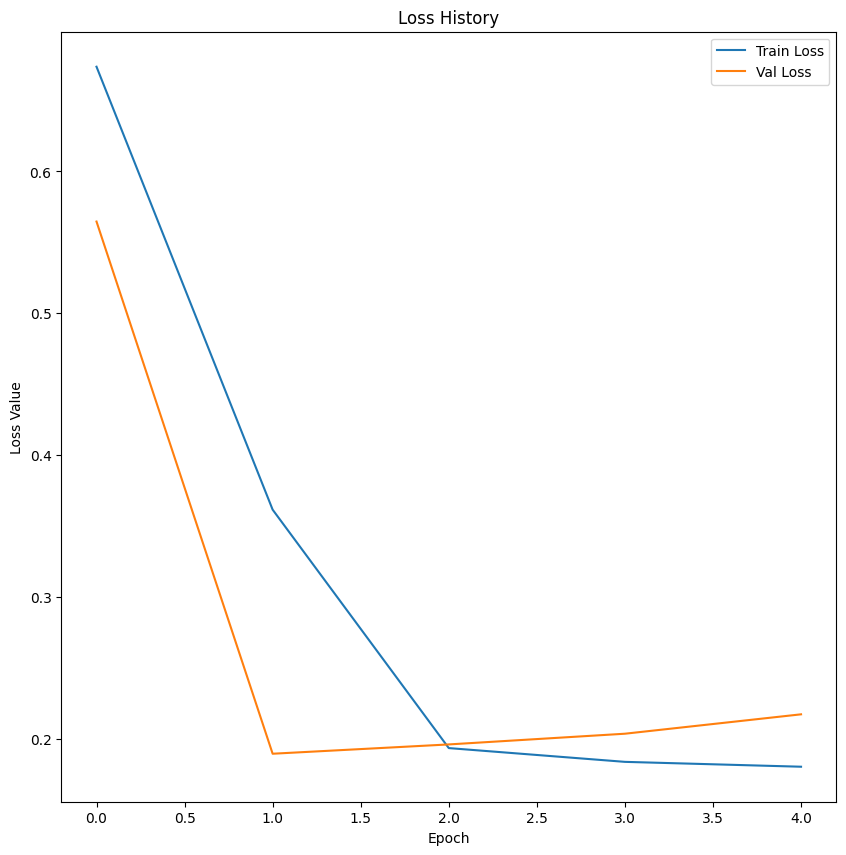

In [41]:
plt.clf()
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

## Plot PR AUC Learning Curves

<Figure size 640x480 with 0 Axes>

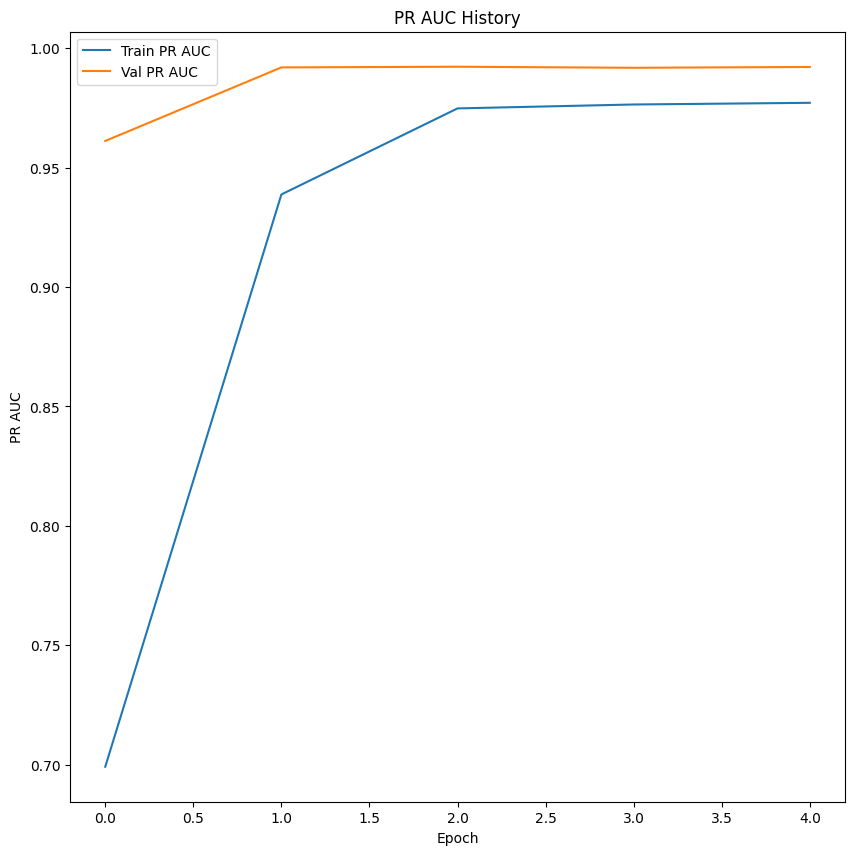

In [42]:
plt.clf()
plt.figure(figsize=(10, 10))
plt.plot(history.history['auc'], label='Train PR AUC')
plt.plot(history.history['val_auc'], label='Val PR AUC')
plt.title('PR AUC History')
plt.ylabel('PR AUC')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

## Load Model with Best Validation Loss from Training Process

In [43]:
model = tf.keras.models.load_model(model_result)

## Generate Test Set Scores

## Test dataset

In [44]:
y_prob = model.predict({"text": padded_inputs_test, "numeric": X_test}).flatten()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [45]:
y_prob

array([0.9541392 , 0.99789375, 0.9931184 , 0.11614592, 0.99066526,
       0.93955356, 0.05553641, 0.02811675, 0.9894177 , 0.9888756 ,
       0.98624414, 0.9889825 , 0.98579425, 0.9523884 , 0.21608488,
       0.78037965, 0.98325706, 0.9952533 , 0.13929267, 0.8486457 ,
       0.0925272 , 0.9771188 , 0.2770666 , 0.9846666 , 0.47476292,
       0.13693611, 0.97822183, 0.9537076 , 0.26220927, 0.98044896,
       0.9769174 , 0.12602867, 0.9878396 , 0.04838131, 0.99140644,
       0.21996272, 0.22774915, 0.9858868 , 0.99260527, 0.9735491 ,
       0.8698693 , 0.97589207, 0.93369037, 0.95352715, 0.97837883,
       0.98610455, 0.96432966, 0.8066503 , 0.9777932 , 0.99470955,
       0.9064053 , 0.9935743 , 0.93116385, 0.07710378, 0.99316365,
       0.98535115, 0.9886148 , 0.64462024, 0.05128775, 0.95544034,
       0.96496236, 0.03660028, 0.98930186, 0.9915554 , 0.13643321,
       0.98737544, 0.08219436, 0.9596067 , 0.9769368 , 0.04629619,
       0.9949237 , 0.99662036, 0.06611228, 0.97763705, 0.97861

In [46]:
len(y_prob)

984

### Plot Precision Recall Curve

/opt/anaconda3/envs/cat_num_text/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


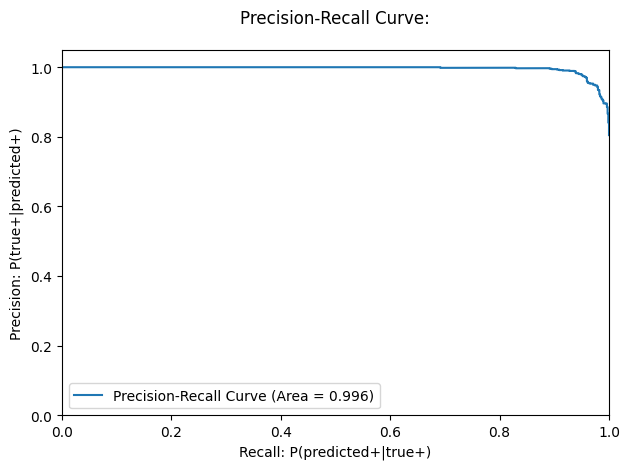

In [47]:
pr_curve(y_test, y_prob)

### Plot Score Distributions for True Positives and True Negatives in Test Set

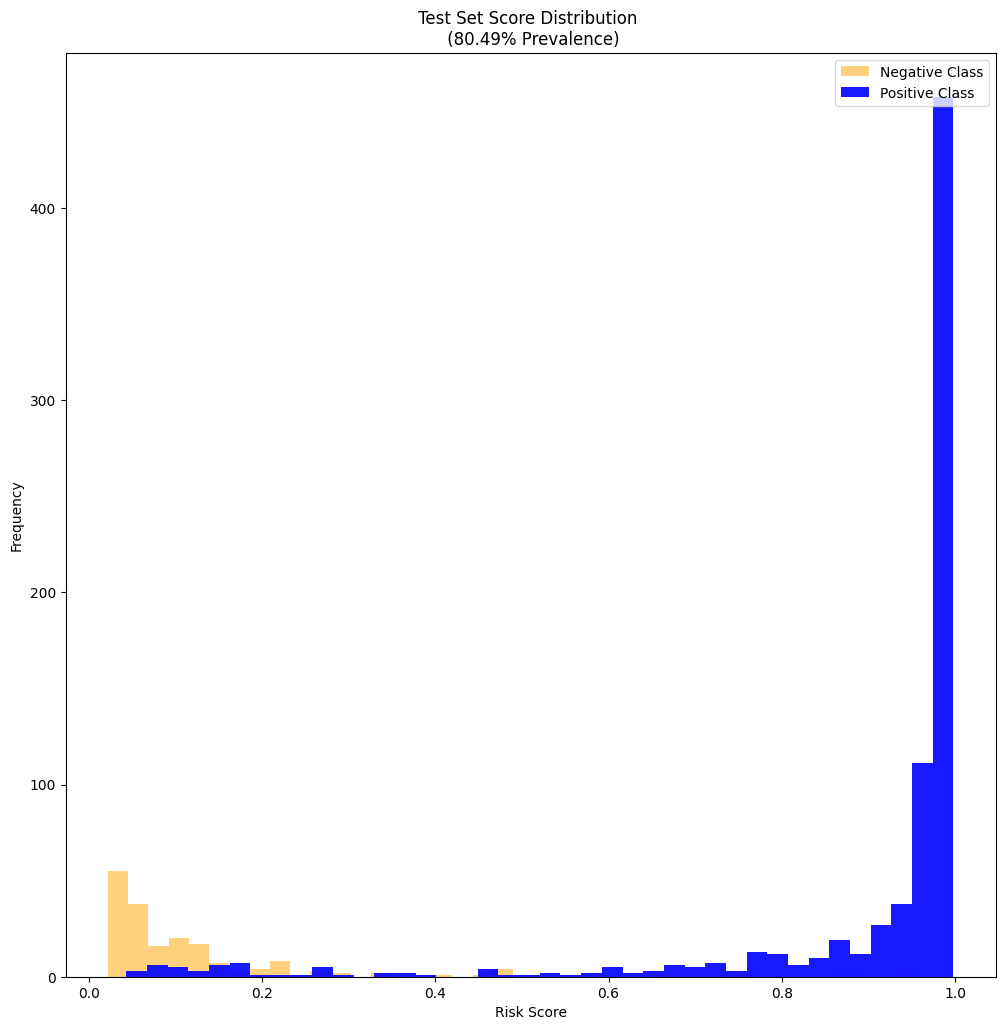

In [48]:
plot_validation_groups(y_test, y_prob)

### Compute Performance Metrics at Threshold Increments

In [49]:
comp_threshold(y_test, y_prob)

,Threshold,Sensitivity,Specificity,Precision,Recall,Accuracy,True Negative Rate,False Positive Rate,False Negative Rate,True Positive Rate,F1 Score,Brier Loss
0,0.05,0.9987,0.3385,0.8617,0.9848,0.8699,6.61%,12.91%,0.1%,80.39%,0.4626,0.1301
1,0.10,0.9861,0.5990,0.9103,0.9127,0.9106,11.69%,7.83%,1.12%,79.37%,0.4733,0.0894
2,0.15,0.9747,0.7865,0.9496,0.8830,0.9380,15.35%,4.17%,2.03%,78.46%,0.4810,0.0620
3,0.20,0.9609,0.8229,0.9572,0.8360,0.9339,16.06%,3.46%,3.15%,77.34%,0.4795,0.0661
4,0.25,0.9583,0.8802,0.9706,0.8366,0.9431,17.17%,2.34%,3.35%,77.13%,0.4822,0.0569
5,0.30,0.9508,0.9062,0.9767,0.8169,0.9421,17.68%,1.83%,3.96%,76.52%,0.4818,0.0579
6,0.35,0.9482,0.9167,0.9791,0.8111,0.9421,17.89%,1.63%,4.17%,76.32%,0.4817,0.0579
7,0.40,0.9444,0.9219,0.9803,0.8009,0.9400,17.99%,1.52%,4.47%,76.02%,0.4810,0.0600
8,0.45,0.9444,0.9323,0.9829,0.8027,0.9421,18.19%,1.32%,4.47%,76.02%,0.4816,0.0579
9,0.50,0.9381,0.9531,0.9880,0.7888,0.9411,18.6%,0.91%,4.98%,75.51%,0.4812,0.0589


### Print Confustion Matrix and Performance Summary at 0.5 Threshold

In [50]:
print_performance(y_test, y_prob)


CONFUSION MATRIX AT 0.5 THRESHOLD:

[[183   9]
 [ 49 743]]

PERFORMANCE AT 0.5 THRESHOLD:

   Recall/Sensitivity: 0.93813
   Specificity: 0.95312
   Precision/Positive Predictive Value: 0.98803
   Negative Predictive Value: 0.78879
   plot_accuracy: 0.94106



## Balanced test dataset

In [51]:
y_prob = model.predict({"text": padded_inputs_test_blncd, "numeric": X_test_blncd}).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [52]:
y_prob

array([0.08359044, 0.04978465, 0.05903681, 0.07744692, 0.7673312 ,
       0.04385363, 0.22265874, 0.0925272 , 0.04485727, 0.9832043 ,
       0.6884262 , 0.9879084 , 0.0476594 , 0.9912191 , 0.97749984,
       0.99028295, 0.9928637 , 0.9783857 , 0.96432966, 0.0445815 ,
       0.93285197, 0.07358715, 0.6954728 , 0.98224986, 0.10745125,
       0.12468395, 0.9930339 , 0.05353717, 0.03757478, 0.9783098 ,
       0.47656038, 0.62823576, 0.04198891, 0.98648673, 0.33618858,
       0.99113846, 0.9835944 , 0.9841919 , 0.7281363 , 0.7930739 ,
       0.96845585, 0.99356407, 0.2581187 , 0.9820981 , 0.18632312,
       0.7856841 , 0.23586865, 0.11703718, 0.9371822 , 0.02229482,
       0.9840129 , 0.03740564, 0.94827956, 0.20899262, 0.9859741 ,
       0.10190481, 0.1040201 , 0.07803263, 0.9851139 , 0.04197859,
       0.06683831, 0.12386972, 0.98066837, 0.98848915, 0.05350626,
       0.981428  , 0.9305955 , 0.05553641, 0.04495417, 0.14960603,
       0.99083734, 0.04045304, 0.9907575 , 0.9881481 , 0.96301

In [53]:
len(y_prob)

352

In [54]:
y_prob = model.predict({"text": padded_inputs_test_blncd, "numeric": X_test_blncd}).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [55]:
y_prob

array([0.08359044, 0.04978465, 0.05903681, 0.07744692, 0.7673312 ,
       0.04385363, 0.22265874, 0.0925272 , 0.04485727, 0.9832043 ,
       0.6884262 , 0.9879084 , 0.0476594 , 0.9912191 , 0.97749984,
       0.99028295, 0.9928637 , 0.9783857 , 0.96432966, 0.0445815 ,
       0.93285197, 0.07358715, 0.6954728 , 0.98224986, 0.10745125,
       0.12468395, 0.9930339 , 0.05353717, 0.03757478, 0.9783098 ,
       0.47656038, 0.62823576, 0.04198891, 0.98648673, 0.33618858,
       0.99113846, 0.9835944 , 0.9841919 , 0.7281363 , 0.7930739 ,
       0.96845585, 0.99356407, 0.2581187 , 0.9820981 , 0.18632312,
       0.7856841 , 0.23586865, 0.11703718, 0.9371822 , 0.02229482,
       0.9840129 , 0.03740564, 0.94827956, 0.20899262, 0.9859741 ,
       0.10190481, 0.1040201 , 0.07803263, 0.9851139 , 0.04197859,
       0.06683831, 0.12386972, 0.98066837, 0.98848915, 0.05350626,
       0.981428  , 0.9305955 , 0.05553641, 0.04495417, 0.14960603,
       0.99083734, 0.04045304, 0.9907575 , 0.9881481 , 0.96301

In [56]:
len(y_prob)

352

## Plot Precision Recall Curve

/opt/anaconda3/envs/cat_num_text/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


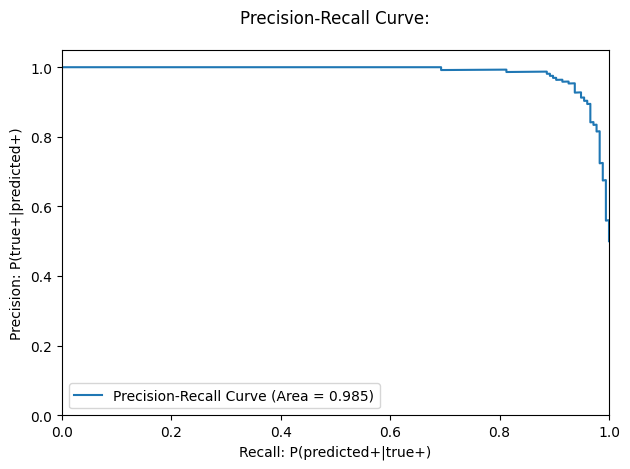

In [57]:
pr_curve(y_test_blncd, y_prob)

## Plot Score Distributions for True Positives and True Negatives in Test Set

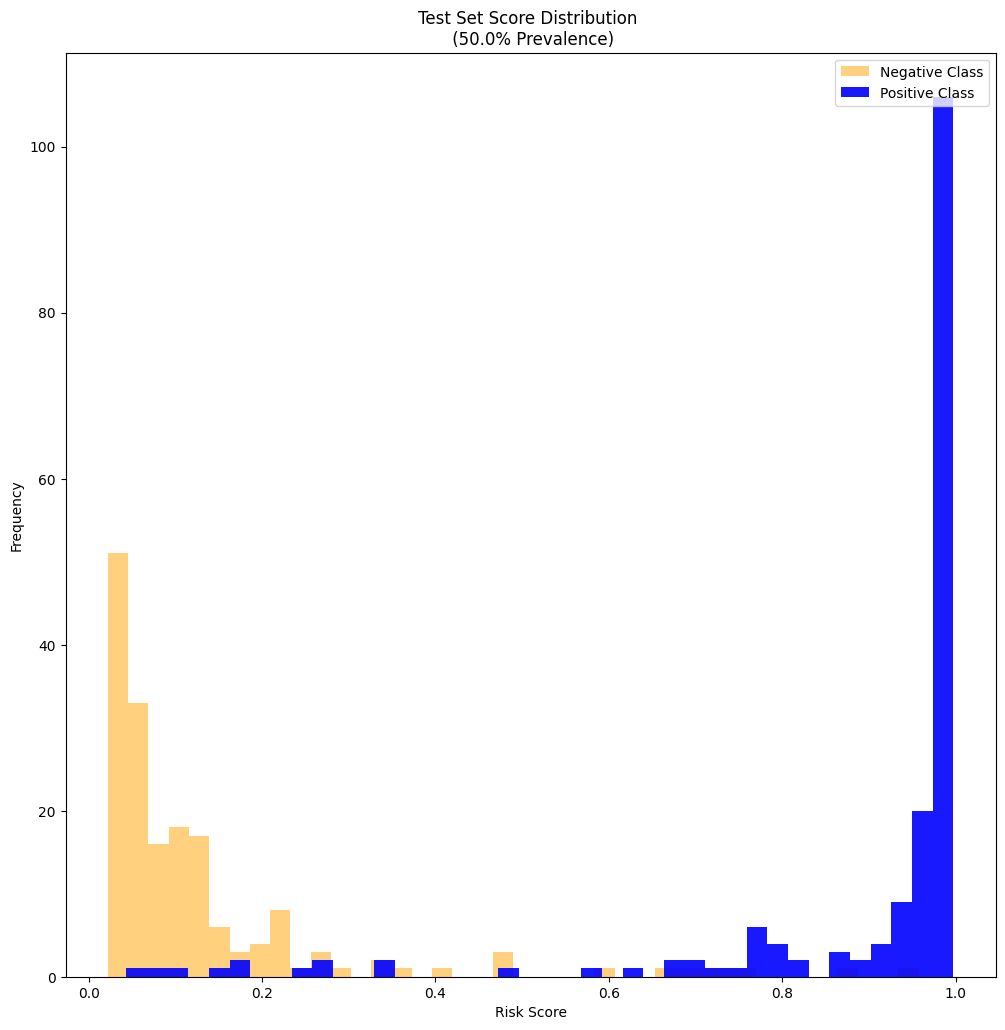

In [58]:
plot_validation_groups(y_test_blncd, y_prob)

## Compute Performance Metrics at Threshold Increments

In [59]:
comp_threshold(y_test_blncd, y_prob)

,Threshold,Sensitivity,Specificity,Precision,Recall,Accuracy,True Negative Rate,False Positive Rate,False Negative Rate,True Positive Rate,F1 Score,Brier Loss
0,0.05,0.9943,0.3409,0.6014,0.9836,0.6676,17.05%,32.95%,0.28%,49.72%,0.3747,0.3324
1,0.10,0.9886,0.5966,0.7102,0.9813,0.7926,29.83%,20.17%,0.57%,49.43%,0.4133,0.2074
2,0.15,0.9773,0.7898,0.8230,0.9720,0.8835,39.49%,10.51%,1.14%,48.86%,0.4468,0.1165
3,0.20,0.9659,0.8295,0.8500,0.9605,0.8977,41.48%,8.52%,1.7%,48.3%,0.4521,0.1023
4,0.25,0.9602,0.8920,0.8989,0.9573,0.9261,44.6%,5.4%,1.99%,48.01%,0.4643,0.0739
5,0.30,0.9489,0.9148,0.9176,0.9471,0.9318,45.74%,4.26%,2.56%,47.44%,0.4665,0.0682
6,0.35,0.9375,0.9261,0.9270,0.9368,0.9318,46.31%,3.69%,3.12%,46.88%,0.4661,0.0682
7,0.40,0.9375,0.9318,0.9322,0.9371,0.9347,46.59%,3.41%,3.12%,46.88%,0.4674,0.0653
8,0.45,0.9375,0.9375,0.9375,0.9375,0.9375,46.88%,3.12%,3.12%,46.88%,0.4688,0.0625
9,0.50,0.9318,0.9545,0.9535,0.9333,0.9432,47.73%,2.27%,3.41%,46.59%,0.4713,0.0568


## Print Confustion Matrix and Performance Summary at 0.5 Threshold

In [60]:
print_performance(y_test_blncd, y_prob)


CONFUSION MATRIX AT 0.5 THRESHOLD:

[[168   8]
 [ 12 164]]

PERFORMANCE AT 0.5 THRESHOLD:

   Recall/Sensitivity: 0.93182
   Specificity: 0.95455
   Precision/Positive Predictive Value: 0.95349
   Negative Predictive Value: 0.93333
   plot_accuracy: 0.94318

